In [165]:
import sys,os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 5)

In [166]:
# read the data
obama_data = pd.read_excel('training-Obama-Romney-tweets.xlsx',names = ['date','time','text','sentiment'],parse_cols = 4,sheetname = 'Obama')
romney_data = pd.read_excel('training-Obama-Romney-tweets.xlsx',names = ['date','time','text','sentiment'],parse_cols = 4,sheetname = 'Romney')

def get_data(data):
    """ get and clean the data """
    data = data.iloc[1:]
    data['text'] = data['text'].values.astype('unicode')
    data['date'] = data['date'].values.astype('str')
    data['time'] = data['time'].values.astype('unicode')
    # remove rows with mixed sentiment
    data = data[data['sentiment'] < 2]
    data.index = range(len(data))
    
    return data

obama_data = get_data(obama_data)
romney_data = get_data(romney_data)
    
print obama_data.head()
print romney_data.head()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus

                  date            time  \
0  2012-10-16 00:00:00  10:28:53-05:00   
1  2012-10-16 00:00:00  10:04:30-05:00   
2  2012-10-16 00:00:00  09:50:08-05:00   
3  2012-10-16 00:00:00  10:00:16-05:00   
4  2012-10-16 00:00:00  09:48:07-05:00   

                                                text sentiment  
0  Kirkpatrick, who wore a baseball cap embroider...         0  
1  #<e>obama</e> debates that Cracker Ass Cracker...         1  
2  @Hollivan @hereistheanswer  Youre missing the ...         0  
3  I was raised as a Democrat  left the party yea...        -1  
4  The <e>Obama camp</e> can't afford to lower ex...         0  
                  date            time  \
0  2012-10-16 00:00:00  09:38:08-05:00   
1  2012-10-16 00:00:00  10:14:18-05:00   
2  2012-10-16 00:00:00  09:27:16-05:00   
3  2012-10-16 00:00:00  10:11:43-05:00   
4  2012-10-16 00:00:00  10:13:17-05:00   

                                                text sentiment  
0  Insidious!<e>Mitt Romney</e>'s Bain 

In [167]:
print obama_data.info()
print obama_data.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5471 entries, 0 to 5470
Data columns (total 4 columns):
date         5471 non-null object
time         5471 non-null object
text         5471 non-null object
sentiment    5471 non-null object
dtypes: object(4)
memory usage: 213.7+ KB
None
                       date  time  \
count                  5471  5471   
unique                   29  5139   
top     2012-10-16 00:00:00   nan   
freq                   1292     5   

                                                     text  sentiment  
count                                                5471       5471  
unique                                               5453          3  
top     I just knew it...<e>Obama</e> was born in Indo...         -1  
freq                                                    3       1922  


In [168]:
print romney_data.info()
print romney_data.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5648 entries, 0 to 5647
Data columns (total 4 columns):
date         5648 non-null object
time         5648 non-null object
text         5648 non-null object
sentiment    5648 non-null object
dtypes: object(4)
memory usage: 220.6+ KB
None
                       date            time  \
count                  5648            5648   
unique                   20            5342   
top     2012-10-16 00:00:00  09:01:31-05:00   
freq                   1713               4   

                                                     text  sentiment  
count                                                5648       5648  
unique                                               5637          3  
top     Ron Paul Won't Endorse <e>Romney</e>, Says Mor...         -1  
freq                                                    2       2893  


In [169]:
import re

def preprocess(data):
    """ preprocess the data"""
    # remove punctuations
    punc = ['\:','\;','\?','\$','\.','\(','\)','\#']
    cond_1 = re.compile('|'.join(punc))
    data['text'] = data['text'].apply(lambda x : re.sub(cond_1,'',x))
    # remove tags
    tags = ['<a>','</a>','<e>','</e>']
    cond_2 = re.compile("|".join(tags))
    data['text'] = data['text'].apply(lambda x : re.sub(cond_2,'',x))
    # remove users
    data['text'] = data['text'].apply(lambda x : re.sub(r'\@\w+','',x))
    # remove hypertext 
    data['text'] = data['text'].apply(lambda x : re.sub(r'http://','',x))
    # remove digits
    data['text'] = data['text'].apply(lambda x : re.sub(r'[0-9]+','',x))
    # convert to ascii
    data['text'] = data['text'].apply(lambda x: x.encode('utf-8'))
    
    return data

obama_data = preprocess(obama_data)
romney_data = preprocess(romney_data)

# Time

In [170]:
def process_time(data):
    """ processes time """

    def extract_date(pattern,string):
        temp = re.match(pattern,string)
        if temp:
            return temp.group(1)
        else:
            return string
    # clean date
    date_format_1 = re.compile('\d+/(\d{2})/\d+')
    date_format_2 = re.compile('\d+\-\d+\-(\d{2})')
    date_format_3 = re.compile('(\d{2})\-[a-zA-Z]+\-\d+')
    date_format = [date_format_1] + [date_format_2] + [date_format_3]

    # remove whitespace
    data['date'] = data['date'].apply(lambda x : x.replace(' ',''))

    for i in date_format:
        data['date'] = data['date'].apply(lambda x: extract_date(i,x))

    def converter(first,second):
        if first == 'AM':
            return second
        else:
            val = re.findall('(\d{1,2})',second)[0]
            if int(val) > 12:
                val = str(int(val) + 12)
            return re.sub('\d{1,2}',val,second,1)

    def extract_time(pattern,string):

        temp = re.match(pattern,string)
        if temp:
            first = temp.group(1)
            second = temp.group(2)
            third = temp.group(3)

            if first is None and third is None:
                return second

            if first == 'AM' or first == 'PM':
                return converter(first,second)
            else:
                return converter(third,second)

    # clean time
    time_format_1 = re.compile('(AM|PM)?\s?(\d{1,2}:\d{1,2}:\d{1,2})\s?(AM|PM)?')

    # remove whitespace
    data['time'] = data['time'].apply(lambda x : x.replace(' ',''))

    data['time'] = data['time'].apply(lambda x : extract_time(time_format_1,x))
    data['time'] = pd.to_datetime(data['time'], format='%H:%M:%S')
    
    return data

-1    1922
 0    1896
 1    1653
Name: sentiment, dtype: int64
-1    2893
 0    1680
 1    1075
Name: sentiment, dtype: int64


<Container object of 10 artists>

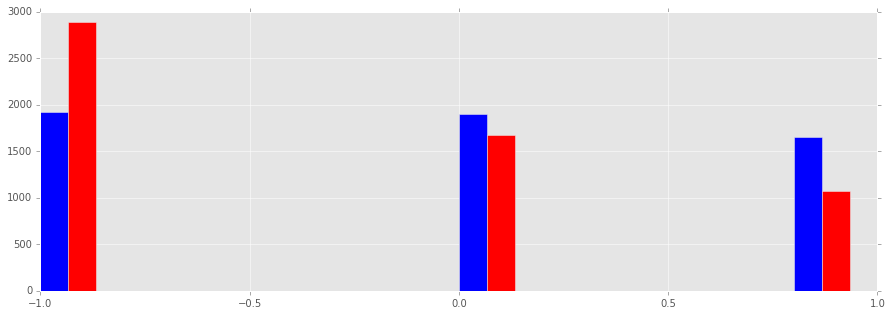

In [171]:
# distribution of sentiment

fig,ax = plt.subplots()

obama_heights,obama_bins = np.histogram(obama_data['sentiment'])
romney_heights,romney_bins = np.histogram(romney_data['sentiment'],bins = obama_bins)

print obama_data['sentiment'].value_counts()
print romney_data['sentiment'].value_counts()

width = (obama_bins[1] - obama_bins[0])/3

ax.bar(obama_bins[:-1],obama_heights,width = width,color = 'blue')
ax.bar(romney_bins[:-1]+width,romney_heights,width = width, color = 'red')

In [172]:
obama_data[:5]

,date,time,text,sentiment
0,2012-10-16 00:00:00,10:28:53-05:00,"Kirkpatrick, who wore a baseball cap embroider...",0
1,2012-10-16 00:00:00,10:04:30-05:00,obama debates that Cracker Ass Cracker tonight...,1
2,2012-10-16 00:00:00,09:50:08-05:00,Youre missing the point Im afraid you do n...,0
3,2012-10-16 00:00:00,10:00:16-05:00,I was raised as a Democrat left the party yea...,-1
4,2012-10-16 00:00:00,09:48:07-05:00,The Obama camp can't afford to lower expectati...,0


In [206]:
## IMP - Process Emoticons, better stopwords list, clean hashtags
# http://stackoverflow.com/questions/8870261/how-to-split-text-without-spaces-into-list-of-words

manual_stopwords_list = ['rt']

In [275]:
# remove stopwords

from nltk.corpus import stopwords

stopwords_list = stopwords.words('english') + manual_stopwords_list

# stemming
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
class Tokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

# Learning

In [286]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.model_selection import KFold
from sklearn.decomposition import TruncatedSVD

def get_X_y(data):
    return data['text'],data['sentiment'].astype(int)

X,y = get_X_y(romney_data)
print X.shape,y.shape

(5648,) (5648,)


In [287]:
stopwords_list = []
# create a pipeline
text_vector = Pipeline([('vect', CountVectorizer(tokenizer = Tokenizer(),stop_words = stopwords_list,ngram_range = (1,2),max_features=10000)),
                    ('tfidf',TfidfTransformer())])
svd_transform = TruncatedSVD(n_components = 1000,n_iter = 5)

In [288]:
# transform the data
X = text_vector.fit_transform(X)
X_reduced = svd_transform.fit_transform(X)

In [289]:
from sklearn.metrics import classification_report,accuracy_score

classifier_scores = dict()

def naive_classifier():
    return 'Naive_Bayes',MultinomialNB()

def svm_classifier():
    return 'Linear_SVM',LinearSVC()

def sgd_classifier():
    return 'SGD',SGDClassifier()

classifiers_list = [naive_classifier(),svm_classifier(),sgd_classifier()]

for clf_name,clf in classifiers_list:
    # dont use reduced matrix for naive bayes
    if clf_name != 'Naive_Bayes':
            X = X_reduced
    classifier_scores[clf_name] = dict()
    classifier_scores[clf_name]['classification_pred'] = cross_val_predict(clf,X,y,cv = 10)

In [290]:
 for clf_name,_ in classifiers_list:
        print 'Classifier - {}'.format(clf_name)
        print 'accuracy is {}'.format(accuracy_score(y,classifier_scores[clf_name]['classification_pred']))
        print classification_report(y,classifier_scores[clf_name]['classification_pred'])
        print '\n'

Classifier - Naive_Bayes
accuracy is 0.561437677054
             precision    recall  f1-score   support

         -1       0.56      0.95      0.70      2893
          0       0.51      0.15      0.24      1680
          1       0.73      0.16      0.26      1075

avg / total       0.58      0.56      0.48      5648



Classifier - Linear_SVM
accuracy is 0.566395184136
             precision    recall  f1-score   support

         -1       0.63      0.75      0.69      2893
          0       0.42      0.35      0.39      1680
          1       0.53      0.41      0.46      1075

avg / total       0.55      0.57      0.55      5648



Classifier - SGD
accuracy is 0.556480169972
             precision    recall  f1-score   support

         -1       0.64      0.71      0.67      2893
          0       0.43      0.37      0.40      1680
          1       0.47      0.45      0.46      1075

avg / total       0.55      0.56      0.55      5648





# Word Vectors

In [18]:
import gensim

embeddings_dict = {}
f = open(os.path.join('glove.twitter.27B', 'glove.twitter.27B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_dict[word] = coefs
f.close()

In [164]:
X,y = get_X_y(obama_data)

In [20]:
class EmbeddingVectorizer(CountVectorizer):
    def __init__(self,**kwargs):
        self.embeddings_dict = kwargs.pop('word2vec')
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = 100
        super(EmbeddingVectorizer,self).__init__(**kwargs)
        
    def fit(self,X,y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.embeddings_dict[w] for w in words if w in self.embeddings_dict]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    
    def fit_transform(self,X,y):
        return self.fit(X,y).transform(X)

In [21]:
# convert to word vectors
text_vector = Pipeline([('vect', EmbeddingVectorizer(word2vec = embeddings_dict,tokenizer = Tokenizer(),stop_words = stopwords_list)),
                ('classifier',LinearSVC())])

In [22]:
k_fold = KFold(10)

scores = []
for train,test in k_fold.split(X,y):
    text_vector.fit_transform(X[train],y[train])
    pred_val = text_vector.predict(X[test])
    scores.append(np.mean(pred_val != y[test]))

print sum(scores)/len(scores)

/usr/local/lib/python2.7/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use esti

0.545231788521


/usr/local/lib/python2.7/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
